In [1]:
import numpy as np
import matplotlib.cm as cmap
import time
import os.path
import scipy
import pickle as pickle
from struct import unpack
from brian2 import *
import brian2
from brian2tools import *

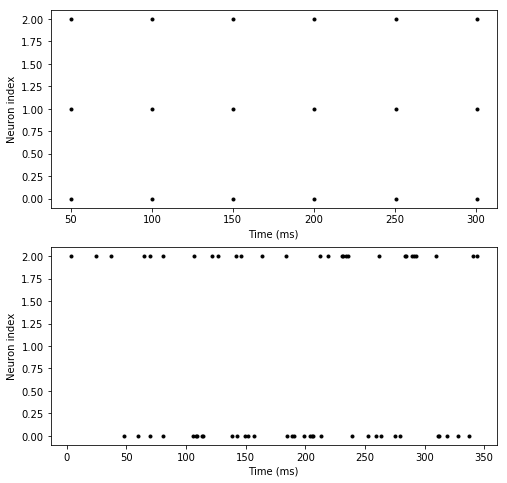

In [98]:
start_scope()

# ///////////////////////////// input poisson group
in_G = PoissonGroup(3, 0*Hz)
in_G.rates = [130, 1, 70] * Hz 

# //////////////////////////// neuron group
v_rest_e = -65. * mV
v_reset_e = -65. * mV    #
v_thresh_e = -52. * mV   #
refrac_e = 5. * ms     #

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV

v_thresh_e_str = '(v > (theta - 20.0*mV + v_thresh_e)) and (timer > refrac_e)'

scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'

e_G = NeuronGroup(3, neuron_eqs_e, threshold= v_thresh_e_str, refractory= refrac_e, reset= scr_e, method='euler')


# ///////////////////////////////////// synapse
tc_pre_ee = 20*ms
tc_post_1_ee = 20*ms
tc_post_2_ee = 40*ms
nu_ee_pre =  0.0001      # learning rate
nu_ee_post = 0.01       # learning rate
wmax_ee = 1.0

eqs_stdp_ee = '''
dpre/dt   =   -pre/(tc_pre_ee)         : 1 (event-driven)
dpost1/dt  = -post1/(tc_post_1_ee)     : 1 (event-driven)
dpost2/dt  = -post2/(tc_post_2_ee)     : 1 (event-driven)
'''
eqs_stdp_pre_ee = 'pre = 1.; w = clip(w + nu_ee_pre * post1, 0, wmax_ee)'
eqs_stdp_post_ee = 'post1 = 1.; post2 = 1.; w = clip(w + nu_ee_post * pre * post2, 0, wmax_ee)'

model = 'w : 1'
pre = ''
post = ''
model += eqs_stdp_ee
pre += eqs_stdp_pre_ee
post = eqs_stdp_post_ee

S = Synapses(in_G, e_G, model=model, on_pre=pre, on_post=post)
minDelay = 0*ms
maxDelay = 10*ms
deltaDelay = maxDelay - minDelay                  # delay after a spike

# S.connect(j='i')
# S.connect(False)
S.connect(True)
S.delay = 'minDelay + rand() * deltaDelay'                       # rand() value between 0 and 1


# /////////////////////////////////// monitor
spm_e = SpikeMonitor(e_G)
spm_in = SpikeMonitor(in_G)

stm_e = StateMonitor(e_G, 'v', record=True)

run(350*ms)

figure(figsize=(8, 8))
subplot(211)
plot(spm_e.t/ms, spm_e.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

subplot(212)
plot(spm_in.t/ms, spm_in.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

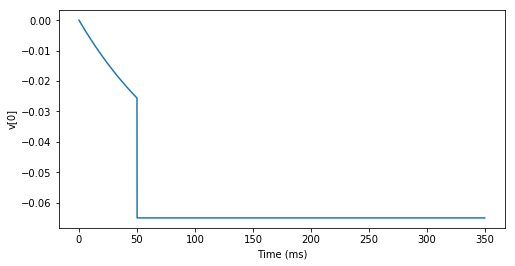

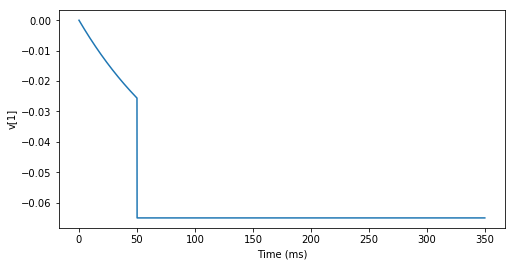

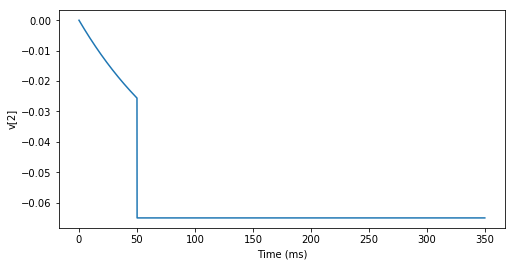

In [116]:
figure(figsize=(8, 4))
plot(stm_e.t/ms, stm_e.v[0])
xlabel('Time (ms)')
ylabel('v[0]');

figure(figsize=(8, 4))
plot(stm_e.t/ms, stm_e.v[1])
xlabel('Time (ms)')
ylabel('v[1]');

figure(figsize=(8, 4))
plot(stm_e.t/ms, stm_e.v[2])
xlabel('Time (ms)')
ylabel('v[2]');

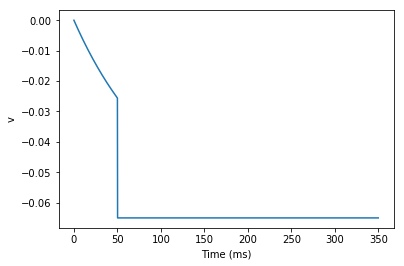

In [96]:
plot(stm_e.t/ms, stm_e.v[1])
xlabel('Time (ms)')
ylabel('v');

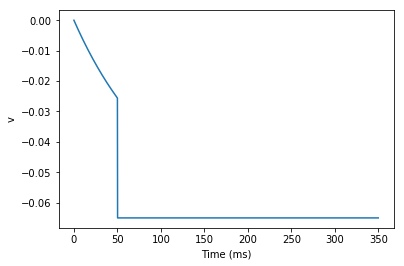

In [97]:
plot(stm_e.t/ms, stm_e.v[2])
xlabel('Time (ms)')
ylabel('v');

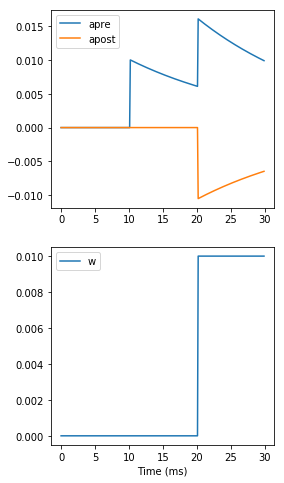

In [55]:
start_scope()

v_rest_e = -65. * mV     #
v_reset_e = -65. * mV    #
v_thresh_e = -52. * mV   #
refrac_e = 5. * ms     #

tc_pre_ee = 20*ms
tc_post_1_ee = 20*ms
tc_post_2_ee = 40*ms
nu_ee_pre =  0.0001      # learning rate
nu_ee_post = 0.01       # learning rate
wmax_ee = 1.0

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''
tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV

v_thresh_e_str = '(v > (theta - 20.0*mV + v_thresh_e)) and (timer > refrac_e)'

scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'

NeuronGroup(n_e, neuron_eqs_e, threshold= v_thresh_e_str, refractory= refrac_e, reset= scr_e, method='euler')

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(n_e, neuron_eqs_e, threshold= v_thresh_e_str, refractory= refrac_e, reset= scr_e, method='euler')

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''', method='linear')
S.connect(i=0, j=1)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(30*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)');

In [40]:
n_e = 10
n_i = 10

v_rest_e = -65. * mV     #
v_rest_i = -60. * mV     #
v_reset_e = -65. * mV    #
v_reset_i = -45. * mV    #
v_thresh_e = -52. * mV   #
v_thresh_i = -40. * mV   #
refrac_e = 5. * ms     #
refrac_i = 2. * ms     #

tc_pre_ee = 20*ms
tc_post_1_ee = 20*ms
tc_post_2_ee = 40*ms
nu_ee_pre =  0.0001      # learning rate
nu_ee_post = 0.01       # learning rate
wmax_ee = 1.0

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''

tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV

v_thresh_e_str = '(v > (theta - 20.0*mV + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v=v_reset_i'

In [41]:
neuron_groups = {}

neuron_groups['Ae'] = NeuronGroup(n_e, neuron_eqs_e, threshold= v_thresh_e_str, refractory= refrac_e, reset= scr_e, method='euler')
neuron_groups['Ai'] = NeuronGroup(n_i, neuron_eqs_i, threshold= v_thresh_i_str, refractory= refrac_i, reset= v_reset_i_str, method='euler')

neuron_groups['Ae'].v = v_rest_e - 40. * mV
neuron_groups['Ai'].v = v_rest_i - 40. * mV

neuron_groups['Ae'].theta = np.ones((n_e)) * 20.0*mV

In [42]:
connections = {}                                                      # XeAe, AeAi, AiAe connections (synapses)

eqs_stdp_ee = '''
dpre/dt   =   -pre/(tc_pre_ee)         : 1 (event-driven)
dpost1/dt  = -post1/(tc_post_1_ee)     : 1 (event-driven)
dpost2/dt  = -post2/(tc_post_2_ee)     : 1 (event-driven)
'''
eqs_stdp_pre_ee = 'pre = 1.; w = clip(w + nu_ee_pre * post1, 0, wmax_ee)'
eqs_stdp_post_ee = 'post1 = 1.; post2 = 1.; w = clip(w + nu_ee_post * pre * post2, 0, wmax_ee)'

# AeAi
# weightMatrix = get_matrix_from_file(weight_path + '/AeAi.npy')
model = 'w : 1'
pre = ''
post = ''

connections['AeAi'] = Synapses(neuron_groups['Ae'], neuron_groups['Ai'], model=model, on_pre=pre, on_post=post)
connections['AeAi'].connect(True)                                          # all-to-all connection
# connections['AeAi'].w = weightMatrix[connections['AeAi'].i, connections['AeAi'].j]

# AiAe
# weightMatrix = get_matrix_from_file(weight_path + '/AiAe.npy')
model = 'w : 1'
pre = ''
post = ''

connections['AiAe'] = Synapses(neuron_groups['Ai'], neuron_groups['Ae'], model=model, on_pre=pre, on_post=post)
connections['AiAe'].connect(True)   # all-to-all connection
# connections['AiAe'].w = weightMatrix[connections['AiAe'].i, connections['AiAe'].j]

In [43]:
n_input = 15
input_groups = {}

delay = {}                                 # ?
delay['ee_input'] = (0*ms, 10*ms) 

input_groups['Xe'] = PoissonGroup(n_input, 0*Hz)

# weightMatrix = get_matrix_from_file(weight_path + '/XeAe.npy')
model = 'w : 1'
pre = ''
post = ''
model += eqs_stdp_ee
pre += eqs_stdp_pre_ee
post = eqs_stdp_post_ee

connections['XeAe'] = Synapses(input_groups['Xe'], neuron_groups['Ae'], model=model, on_pre=pre, on_post=post)
minDelay = delay['ee_input'][0]
maxDelay = delay['ee_input'][1]
deltaDelay = maxDelay - minDelay                  # delay after a spike

# TODO: test this  ?????????????
connections['XeAe'].connect(True) # all-to-all connection
connections['XeAe'].delay = 'minDelay + rand() * deltaDelay'                       # rand() value between 0 and 1
# connections['XeAe'].w = weightMatrix[connections['XeAe'].i, connections['XeAe'].j]

In [44]:
input_groups['Xe'].rates = 30 * Hz 

In [45]:
rate_monitors = {}             # Ae, Ai neuron groups
spike_monitors = {}            # Ae, Ai neuron group
spike_counters = {}            # Ae neuron group

rate_monitors['Ae'] = PopulationRateMonitor(neuron_groups['Ae'])
rate_monitors['Ai'] = PopulationRateMonitor(neuron_groups['Ai'])

spike_counters['Ae'] = SpikeMonitor(neuron_groups['Ae'])

spike_monitors['Ae'] = SpikeMonitor(neuron_groups['Ae'])
spike_monitors['Ai'] = SpikeMonitor(neuron_groups['Ai'])

rate_monitors['Xe'] = PopulationRateMonitor(input_groups['Xe'])

In [46]:
M = StateMonitor(neuron_groups['Ae'], 'v', record=True)

In [47]:
net = Network()                                                                 # main simulation controller in brian2
for obj_list in [neuron_groups, input_groups, connections, rate_monitors, spike_monitors, spike_counters]:
    for key in obj_list:
        print(key)
        net.add(obj_list[key])

Ae
Ai
Xe
AeAi
AiAe
XeAe
Ae
Ai
Xe
Ae
Ai
Ae


In [50]:
net.run(0.400*second, report='text')

Starting simulation at t=0.35 s for a duration of 0.4 s
0.4 (100%) simulated in 1s


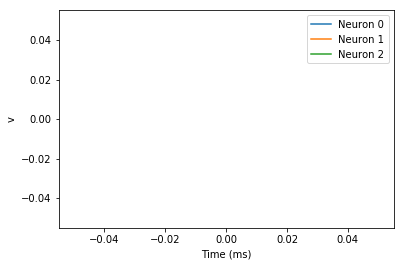

In [51]:
plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();